In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_bert_base_cased'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'bert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A1', 1: 'A12', 2: 'A7', 3: 'A16', 4: 'A8', 5: 'A22', 6: 'A4', 7: 'A11', 8: 'A14', 9: 'A9', 10: 'A17'}
dict_values(['A1', 'A12', 'A7', 'A16', 'A8', 'A22', 'A4', 'A11', 'A14', 'A9', 'A17'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

1


<All keys matched successfully>

### Data loading

In [7]:
en_test_df = pd.read_csv(pathjoin(DATA_DIR, 'en'))
en_test_df.head()

,Unnamed: 0,target,text
0,0,A4,"Governor-Lords of the Imperium , as it was rel..."
1,1,A4,The man could not even gain the daily bread . ...
2,2,A4,Of the two children her son had saved and insi...
3,3,A4,Krork we felt that brand-consciousness eradica...
4,4,A4,His sisters for their savings--would they desp...


In [8]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

11


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.5714285714285714 precision 0.8 recall 0.4444444444444444
label (fictive) f1_score 0.975609756097561 precision 1.0 recall 0.9523809523809523
label (instruct) f1_score 0.8837209302325583 precision 0.95 recall 0.8260869565217391
label (reporting) f1_score 0.6666666666666667 precision 0.65 recall 0.6842105263157895
label (legal) f1_score 0.8780487804878048 precision 0.9 recall 0.8571428571428571
label (personal) f1_score 0.6470588235294117 precision 0.55 recall 0.7857142857142857
label (commercial) f1_score 0.9268292682926829 precision 0.95 recall 0.9047619047619048
label (research) f1_score 0.6206896551724138 precision 0.45 recall 1.0
label (info) f1_score 0.5945945945945946 precision 0.55 recall 0.6470588235294118
label (eval) f1_score 0.0 precision 0.0 recall 0.0
label (stuff) f1_score 0.5762711864406781 precision 0.85 recall 0.4358974358974359
accuracy 0.6954545454545454


/home/mlepekhin/anaconda3/envs/mlepekhin_research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments/interpretation.py:70: RuntimeWarning: invalid value encountered in true_divide
  normed_cm = (cm.T / sums).T


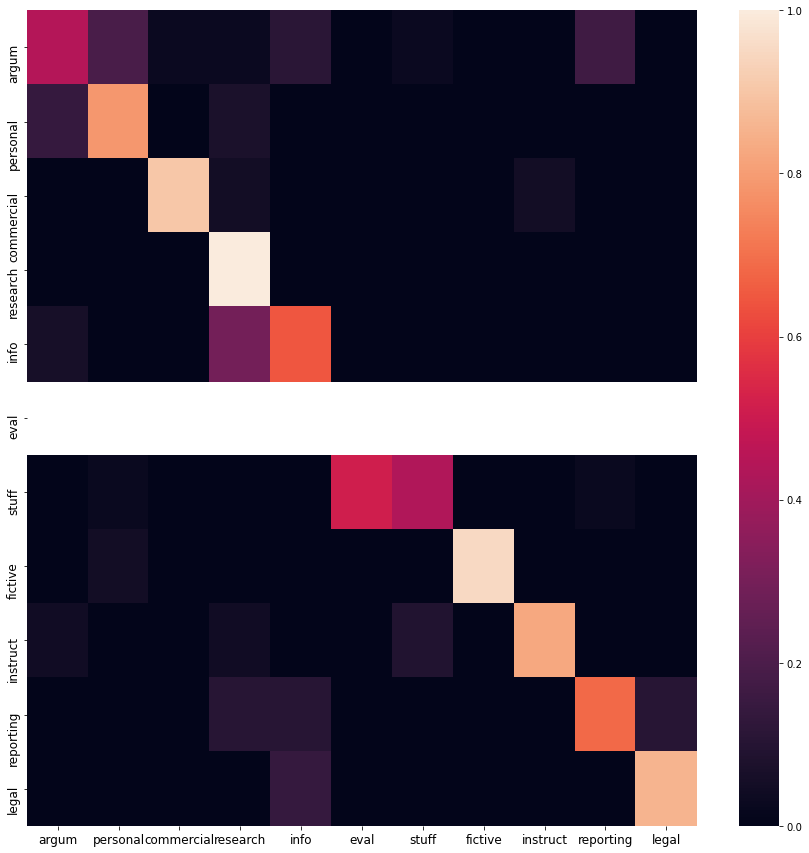

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [14]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [15]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [16]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: instruct
LABEL: commercial
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
But ##ton Parents offered these supported browser ##s : Fire ##fo ##x 3 and later versions , Sa ##fari 5 for Mac and later versions , Internet Explorer 8 , and Google Ch ##rome 5 and later versions you previously disabled auto ##com ##ple ##te you previously opted out of Google In ##stant you use a Google domain or interface language that does not yet support Google In ##stant In addition , users on particularly slow Internet connections w ##o n ' t see dynamic results since we want to make sure that your search experience is as fast as possible . Lea ##rn more about this and similar issues . Last ##ly , certain types of search que ##ries that may be inappropriate will not trigger results to appear automatically . In these situations , you ' ll see a message asking you to click En ##ter to perform the search . The benefits Get all the benefits of auto ##com ##p

In [17]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: research
LABEL: reporting
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
T ##AG ) . The group had noted that a back - to - back meeting would unfortunately not be feasible for 2002 as originally decided at CO ##P 7 ( decision 31 / CP . 7 , paragraph 5 ) . The C ##GE , however , had stressed the importance of ex ##changing views between the two groups through the two common members , the consideration of each group ' s reports and the participation of experts from the L ##EG at the C ##GE workshops . The C ##GE had also discussed the provision of financial resources for the preparation of the second national communications . In the light of the gaps and constraints identified in the preparation of the initial national communications , the C ##GE recognized that it might be necessary to increase the financial resources to improve the process of the preparation of national communications ; I ##dent ##ify the difficulties encountered by 

In [18]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: research
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
C program ##mable industrial systems through education , information exchange , and the el ##ab ##oration of standards and guidelines " ( E ##WI ##CS , n . d . ) , and the Re ##SI ##ST network of excellence ( Re ##SI ##ST , n . d . ) , b ##oast ##ing a 50 - million items re ##si ##lie ##nce knowledge base ( Anderson , Andrews , & Fitzgerald , 2007 ) , which developed a re ##si ##lient computing curriculum recommended to all people involved in teaching depend ##ability - related subjects . La ##p ##rie ' s is the most famous and accepted definition of depend ##ability , but it is certainly not the only one . Not surprisingly , due to the societal relevance of such a topic , depend ##ability has also slightly different definitions ( Mo ##te ##t & G ##ef ##f ##roy , 2003 ) . According to So ##mmer ##villa ( So ##mmer ##villa , 2006 ) , for instance , depend ##ability i